<center> <a href = AWS.ipynb>Use of AWS &lt;</a> | <a href = Standards.ipynb>&gt; Jupyter Standards</a> </center>

# How are special features used in Jupyter
Including Magic, Bash, and Documentation Queries.
Looking only at Python notebooks

## Results Summary:
- 44% of all Python notebooks use at least one of these special features.
- 41% of Python notebooks use at least one magic command.
    - The most common magic use, by far, is %matplotlib with nearly 1.6 million uses.  Following that, %time is the next most popular at 300,000 uses.
    - Among notebooks with at least one magic function, the median number of magic commands is 1 (mean = 1.84)
- 6.1% of Python notebooks use at least one bash command. 
    - Among notebooks with at least one bash command, the median number of bash commands is 2 (mean = 3.26).
    - The most frequently used bash commands are pip to install new packages, ls to list the contents of the current directory, wget to download a file from online, and cat to display the contents of a file.
- Documentation queries are only found in 0.97% of notebooks. 
    - Among these notebooks, the median number of queries is 1 (mean = 1.64).
    - Queries tend to focus on Pandas (read_csv, Series, fillna, drop), Numpy (array, arange), Matplotlib (plot, subplot), and base Python (print, range, len, and zip).
-----



# Import Packages and Load Data

In [1]:
import pandas as pd
import load_data
import datetime
import pickle
import re
import matplotlib.pyplot as plt

Load dataframes

In [2]:
notebooks_temp = load_data.load_notebooks()
special_df_temp = load_data.load_special()
nb_imports_temp = load_data.load_nb_imports()

Notebooks loaded in 0:00:24.607210
Special functions loaded in 0:00:09.411588
Notebook imports loaded in 0:00:36.353610


### Only looking at Python Notebooks

In [3]:
notebooks = notebooks_temp.copy()[notebooks_temp.lang_name == 'python']
special_df = special_df_temp.copy()[special_df_temp.file.isin(notebooks.file)]
nb_imports = nb_imports_temp.copy()[nb_imports_temp.file.isin(notebooks.file)]

In [4]:
del special_df_temp
del notebooks_temp
del nb_imports_temp

---
# Manipulate Data

Add magic, bash, and documentation queries to special dataframe

In [5]:
def in_quotes(c):
    in_single = False
    in_double = False
    for char in c:
        if char == "'":
            in_single = not in_single
        elif char == '"':
            in_double = not in_double
        elif char == '!':
            return (in_single or in_double)

In [6]:
def after_ok(c):
    if c.startswith('!'):
        return True
    else:
        return c.split('!')[0][-1] in [' ','=']

In [7]:
def is_string(possible_string):
    possible_string = re.sub('(?<=[a-zA-Z_])[0-9/.]','',possible_string)
    return len(re.sub('[A-Za-z_/.]','',possible_string)) == 0

In [8]:
special_df['magic'] = [
    [c for c in code if c.startswith('%') 
        and not c.startswith('% ') 
        and not c.startswith('%% ') 
        and len(c.replace('%','').split()) > 0
        and is_string(c.replace('%','').split()[0])
        and c not in ['%','%%']
    ] 
    for code in special_df.code
]

i = 0
bash = []
for code in special_df.code:
    this_bash = []
    for c in code:
        if ('!' in c.split('#')[0]
        and len(c.split('#')[0].split('!')) > 1
        and c.split('#')[0].split('!')[1].strip() != ''
        and not c.split('#')[0].endswith('!')
        and not in_quotes(c)
        and after_ok(c)
        and not c.split('#')[0].split('!')[1].startswith('=')
        and not c.split('#')[0].split('!')[1].startswith('<')
        and not c.split('#')[0].split('!')[1].startswith('>')):
            this_bash.append(c.split('#')[0].split('!')[1].split()[0])
                
    bash.append(this_bash)
    i += 1
special_df['bash'] = bash

special_df['doc'] = [
    [c.split('#')[0].strip() for c in code if 
        c.startswith('?') or (
            c.split('#')[0].endswith('?') 
            and not c.split('#')[0].endswith(' ?')
        )
        and len(c.replace('?','').split('#')[0].strip().split()) == 1
        and is_string(c.replace('?','').split()[0])
        and c != '?'
        and c.split('#')[0].count('?')<3
    ] 
    for code in special_df.code
]
added = False
replaced_im = False

In [9]:
if 'imports' not in special_df.columns:
    special_df = special_df.merge(nb_imports[['file','imports']], on = 'file')

In [10]:
special_df['num_doc'] = [len(d) for d in special_df.doc]
i = 0

In [11]:
if not replaced_im:
    def replace_alias(row):
        doc = special_df.loc[row].doc
        new_doc = []
        imports = special_df.loc[row].imports
        for d in doc:
            for im in imports:
                if im[1] in d:
                    d = re.sub('(?<![a-zA-Z_])'+im[1]+'(?![a-zA-Z_])',im[0],d)
            new_doc.append(d)
        special_df.at[row, 'doc'] = new_doc

    for i in special_df[special_df.num_doc>0].index[
        special_df[special_df.num_doc>0].index > i
    ]:
        replace_alias(i)
    replaced_im = True

In [12]:
bash_commands = pd.Series([
    b.replace('!','').split()[0] 
    for b in load_data.flatten(special_df['bash'])
]).value_counts().index

In [13]:
special_df['num_magic'] = [len(m) for m in special_df.magic]
special_df['num_bash'] = [len(b) for b in special_df.bash]
special_df['num_doc'] = [len(d) for d in special_df.doc]
special_df['num_special'] = special_df['num_magic'] + special_df['num_bash'] + special_df['num_doc']


In [14]:
special_df['doc'] = [[d for d in doc if is_string(d.replace('?',''))] for doc in special_df['doc']]
special_df['num_doc'] = [len(doc) for doc in special_df['doc']]

---
# Visualizations and Statistics

In [15]:
print("{0}% of notebooks use at least one special feature.".format(
    round(100*sum(special_df.num_special > 0) / len(special_df), 2)
))

print("Among notebooks that use at least one special feature, there is an average of {0} uses per notebook (median = {1}).".format(
    round(special_df[special_df.num_special > 0].num_special.mean(), 2),
    special_df[special_df.num_special > 0].num_special.median()
))

44.39% of notebooks use at least one special feature.
Among notebooks that use at least one special feature, there is an average of 2.19 uses per notebook (median = 1.0).


# Magic

## What are the most popular magic commands

In [16]:
magic_cell_uses = pd.Series([
    c.split()[0][2:] for c in load_data.flatten(special_df.magic) 
    if c.startswith('%%')
])
magic_line_uses = pd.Series([
    c.split()[0][1:] for c in load_data.flatten(special_df.magic) 
    if c.startswith('%') and not c.startswith('%%')
])
magic_counts = pd.concat([magic_cell_uses, magic_line_uses]).value_counts().reset_index().rename(columns = {'index':'magic', 0:'num_uses'})

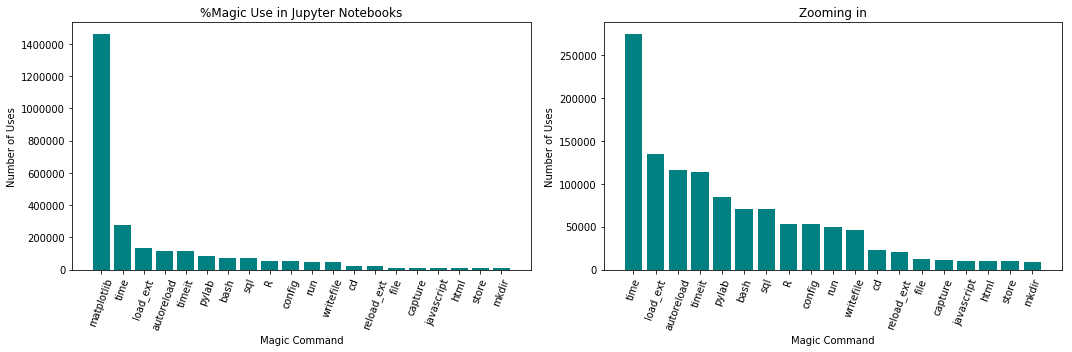

In [17]:
fig = plt.figure(figsize = (15, 5))

plt.subplot(1,2,1)
x = magic_counts[:20].magic
x_pos = range(len(x))
y = magic_counts[:20].num_uses
plt.bar(x_pos, y, color = 'teal')
plt.xticks(x_pos, x, rotation = 70)
plt.ylabel('Number of Uses')
plt.xlabel('Magic Command')
plt.title('%Magic Use in Jupyter Notebooks')

plt.subplot(1,2,2)
x = magic_counts[1:20].magic
x_pos = range(len(x))
y = magic_counts[1:20].num_uses
plt.bar(x_pos, y, color = 'teal')
plt.xticks(x_pos, x, rotation = 70)
plt.ylabel('Number of Uses')
plt.xlabel('Magic Command')
plt.title('Zooming in')

plt.tight_layout()
plt.show()

## How are magic functions used

In [18]:
print("{0}% of magic uses are for a line, and the other {1}% for a whole cell.".format(
    round(100*len(magic_line_uses)/(len(magic_line_uses) + len(magic_cell_uses)), 2),
    round(100*len(magic_cell_uses)/(len(magic_line_uses) + len(magic_cell_uses)), 2)
))

81.24% of magic uses are for a line, and the other 18.76% for a whole cell.


## How many magic functions are used

In [19]:
print("{0}% of notebooks use at least one magic function. Among notebooks that have at least one magic use, the average is {1} uses per notebook (median = {2}).".format(
    round(100*sum(special_df.num_magic > 0) / len(special_df), 2),
    round(special_df[special_df.num_magic > 0].num_magic.mean(), 2),
    special_df[special_df.num_magic > 0].num_magic.median()
))

41.31% of notebooks use at least one magic function. Among notebooks that have at least one magic use, the average is 1.83 uses per notebook (median = 1.0).


What percent use non matplotlib

In [20]:
print("The notebook with the most magic uses has {0} uses. This can be found at: {1}.".format(
    special_df.num_magic.max(),
    notebooks[notebooks.file == special_df[special_df.num_magic == special_df.num_magic.max()].file.values[0]].html_url.values[0]
))

The notebook with the most magic uses has 366 uses. This can be found at: https://github.com/vlawlor/Kid-PRT/blob/fc2c4a9383650be30a91518ee632a5db98b07e28/KIDPRT.ipynb.


# Bash

## What bash commands do people execute in notebooks

In [21]:
bash_counts = pd.Series([
    c.replace('!','').split()[0] 
    for c in load_data.flatten(special_df.code) 
    if c.startswith('!') and len( c.replace('!','').split()) > 0
]).value_counts().reset_index().rename(columns = {'index':'bash', 0:'num_uses'})

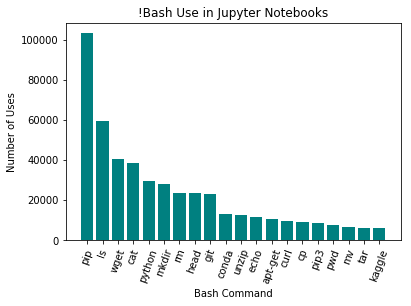

In [22]:
x = bash_counts[:20].bash
x_pos = range(len(x))
y = bash_counts[:20].num_uses
plt.bar(x_pos, y, color = 'teal')
plt.xticks(x_pos, x, rotation = 70)
plt.ylabel('Number of Uses')
plt.xlabel('Bash Command')
plt.title('!Bash Use in Jupyter Notebooks')
plt.show()

## How many bash commands are used

In [23]:
print("{0}% of notebooks use at least one bash command. Among notebooks that have at least one bash command, the average is {1} uses per notebook (median = {2}).".format(
    round(100*sum(special_df.num_bash > 0) / len(special_df), 2),
    round(special_df[special_df.num_bash > 0].num_bash.mean(), 2),
    special_df[special_df.num_bash > 0].num_bash.median()
))

6.05% of notebooks use at least one bash command. Among notebooks that have at least one bash command, the average is 3.27 uses per notebook (median = 2.0).


In [24]:
print("The notebook with the most bash commands has {0} uses. This can be found at: {1}.".format(
    special_df.num_bash.max(),
    notebooks[notebooks.file == special_df[special_df.num_bash == special_df.num_bash.max()].file.values[0]].html_url.values[0]
))

The notebook with the most bash commands has 409 uses. This can be found at: https://github.com/tylerdann/2014-Bird-Creek-linkage-map/blob/2b8ae9832a23bbf9f0c8edd91c6119b2ce909d1f/2014%20Bird%20Creek%20linkage%20map.ipynb.


# Documentation

## What documentation do people search for

In [25]:
doc_counts = pd.Series(
    [d.replace('?','') for d in load_data.flatten(special_df.doc) if d.replace('?','')!='']
).value_counts().reset_index().rename(columns = {'index':'doc', 0:'num_uses'})

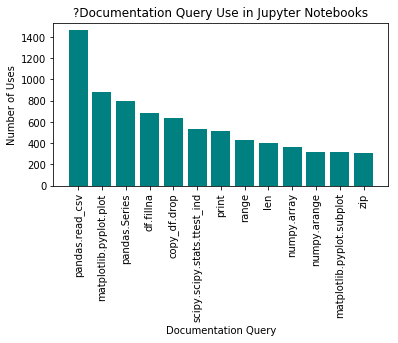

In [26]:
fig = plt.figure(figsize = (6, 3))
x = doc_counts[doc_counts.num_uses > 300].doc
x_pos = range(len(x))
y = doc_counts[doc_counts.num_uses > 300].num_uses
plt.bar(x_pos, y, color = 'teal')
plt.xticks(x_pos, x, rotation = 90)
plt.ylabel('Number of Uses')
plt.xlabel('Documentation Query')
plt.title('?Documentation Query Use in Jupyter Notebooks')
plt.show()

## How many documentation queries are used

In [27]:
print("{0}% of notebooks use at least one documentation query. Among notebooks that have at least one documentation query, the average is {1} uses per notebook (median = {2}).".format(
    round(100*sum(special_df.num_doc > 0) / len(special_df), 2),
    round(special_df[special_df.num_doc > 0].num_doc.mean(), 2),
    special_df[special_df.num_doc > 0].num_doc.median()
))

0.97% of notebooks use at least one documentation query. Among notebooks that have at least one documentation query, the average is 1.64 uses per notebook (median = 1.0).


In [28]:
print("The notebook with the most documentation queries has {0} uses. This can be found at: {1}.".format(
    special_df.num_doc.max(),
    notebooks[notebooks.file == special_df[special_df.num_doc == special_df.num_doc.max()].file.values[0]].html_url.values[0]
))

The notebook with the most documentation queries has 68 uses. This can be found at: https://github.com/rohitsharma123123/finalnow/blob/89c826bf51ea86a7baf78060d5a590e3edc2e0cf/Notebook_wlstm_ga.ipynb.


<center> <a href = AWS.ipynb>Use of AWS &lt;</a> | <a href = Standards.ipynb>&gt; Jupyter Standards</a> </center>